### Импорт необходимых библиотек

In [ ]:
import urllib3
import pandas as pd
import numpy as np
import random

from keycloak import KeycloakOpenID
from openai import AsyncClient
from catboost import CatBoostClassifier
import umap.umap_ as umap
from hdbscan import HDBSCAN
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt


urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Настройка доступов, аутентификация и инициализация клиента для эмбеддингов


In [ ]:
import os
from openai import Client
import httpx

lm_api_url = ""

client = Client(base_url=lm_api_url, api_key="TOKEN", http_client=httpx.Client(verify=False))

### Загрузка данных и предобработка

In [2]:
import dill

with open('path/to/embeddings.pkl', 'rb') as f:
    old_stuff = dill.load(f)

In [3]:
import pandas as pd
df = pd.DataFrame(old_stuff)

### Уменьшение размерности с помощью UMAP

In [ ]:
umap_model = umap.UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    # random_state=42 - setting seed blocks parallelism
)

reduced_embeddings = umap_model.fit_transform(df.embedding.values.tolist())

In [ ]:
embedding_dict = {i:j for i, j in zip(df.purpose.values, reduced_embeddings)}

### Кластеризация на большие кластеры

In [ ]:
hdbscan_model = HDBSCAN(
    min_cluster_size=1000,
    metric="euclidean",
    cluster_selection_method="leaf",
    gen_min_span_tree=True,
)

clusters = hdbscan_model.fit_predict(reduced_embeddings)

In [26]:
from collections import Counter
Counter(clusters)

Counter({np.int64(-1): 99200,
         np.int64(5): 10530,
         np.int64(23): 8044,
         np.int64(0): 5338,
         np.int64(14): 5000,
         np.int64(20): 4561,
         np.int64(12): 4131,
         np.int64(3): 3447,
         np.int64(25): 2960,
         np.int64(19): 2762,
         np.int64(13): 2308,
         np.int64(1): 2006,
         np.int64(7): 1917,
         np.int64(24): 1915,
         np.int64(21): 1837,
         np.int64(4): 1486,
         np.int64(9): 1446,
         np.int64(8): 1427,
         np.int64(10): 1406,
         np.int64(17): 1405,
         np.int64(15): 1403,
         np.int64(22): 1394,
         np.int64(6): 1343,
         np.int64(16): 1210,
         np.int64(2): 1193,
         np.int64(11): 1160,
         np.int64(18): 1045})

In [ ]:
umap_model2 = umap.UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    # random_state=42
)

reduced_embeddings2 = umap_model.fit_transform(df.embedding.values.tolist())

/var/folders/1p/r5nrs13x0nb6qfb1xtb7ncl06v0pq3/T/ipykernel_31754/284692597.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)


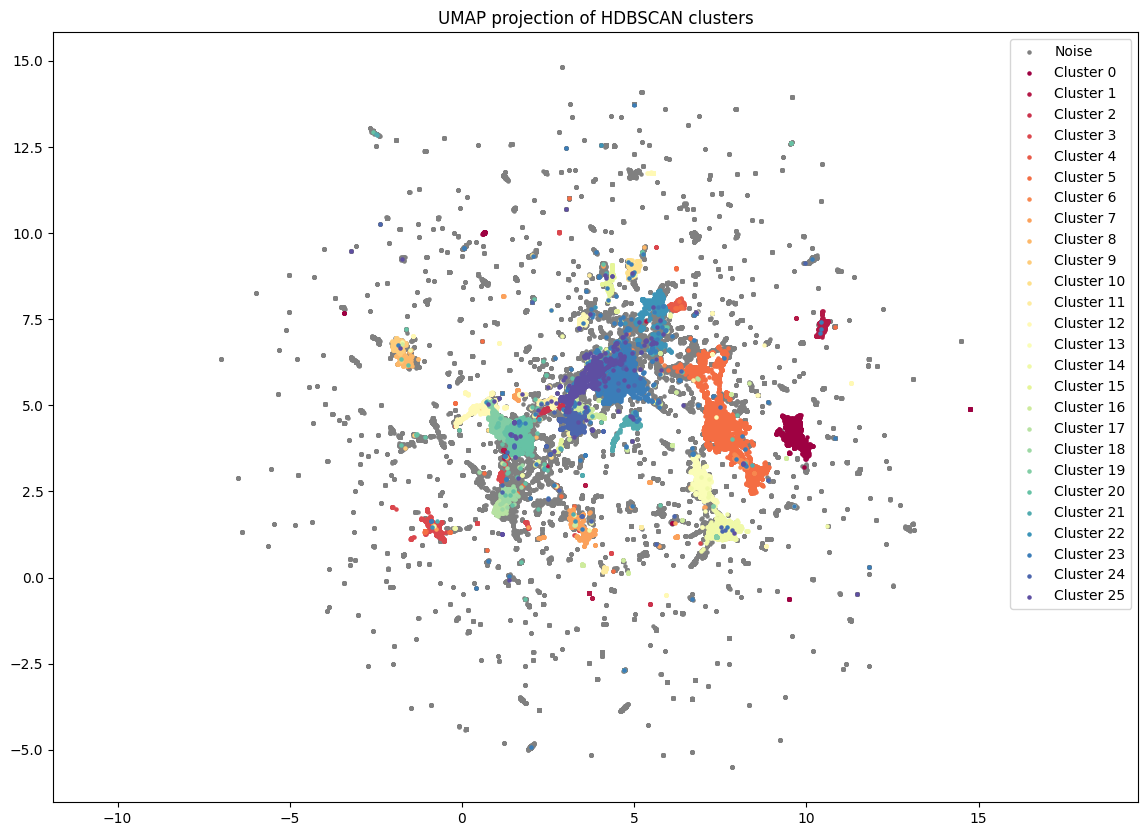

In [32]:
# Create a custom colormap where -1 (noise) is gray
unique_labels = np.unique(clusters)
cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)
cmap.set_over('gray')  # Set color for noise points (-1)

# Plot the clusters
plt.figure(figsize=(14, 10))

# Plot noise points in gray
noise_points = reduced_embeddings2[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='gray', s=5, label='Noise')

# Plot other clusters
for label in unique_labels[unique_labels != -1]:
    cluster_points = reduced_embeddings2[clusters == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(label)], s=5, label=f'Cluster {label}')

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of HDBSCAN clusters')
plt.legend()
plt.show()

In [44]:
cluster_texts = defaultdict(list)
for text, cluster, index in zip(df.purpose.values, clusters, [i for i in range(len(clusters))]):
    cluster_texts[int(cluster)].append((text, index))

cluster_texts = dict(cluster_texts)


In [43]:
df['cluster'] = clusters

### Идея: из каждого кластера берём по немного из ближней, средней и дальней зон от центроида, чтобы получить разнообразные примеры

In [40]:
def compute_centroid(vectors: np.ndarray) -> np.ndarray:
    return vectors.mean(axis=0)


def sample_zone(zone, k):
    if len(zone) <= k:
        return zone
    else:
        return random.sample(zone, k)

In [59]:
SAMPLES_PER_ZONE = 40
sample_for_annotation = []


for cluster_id, texts in cluster_texts.items():
    if not texts:
        continue
    idx = [i[1] for i in texts]
    texts = [i[0] for i in texts]
    cluster_vectors = np.array([embedding_dict[t] for t in texts])
    centroid = compute_centroid(cluster_vectors)
    distances = np.linalg.norm(cluster_vectors - centroid, axis=1)

    text_dist_pairs = list(zip(texts, distances, idx))
    text_dist_pairs.sort(key=lambda x: x[1])
    
    n = len(text_dist_pairs)
    near_boundary = n // 3
    mid_boundary = 2 * n // 3
    
    near_zone = text_dist_pairs[:near_boundary]
    mid_zone  = text_dist_pairs[near_boundary:mid_boundary]
    far_zone  = text_dist_pairs[mid_boundary:]
    
    near_samples = sample_zone(near_zone, SAMPLES_PER_ZONE)
    mid_samples = sample_zone(mid_zone, SAMPLES_PER_ZONE)
    far_samples = sample_zone(far_zone, SAMPLES_PER_ZONE)


    
    for (txt, dist, idx) in (near_samples + mid_samples + far_samples):
        sample_for_annotation.append((cluster_id, txt, dist, idx))

final_texts_for_annotation = [item[1] for item in sample_for_annotation]

print(f"Всего выбрано {len(final_texts_for_annotation)} текстов для разметки.")

Всего выбрано 3240 текстов для разметки.


In [63]:
sampled_idxs = [i[-1] for i in sample_for_annotation]

/var/folders/1p/r5nrs13x0nb6qfb1xtb7ncl06v0pq3/T/ipykernel_31754/1917583072.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)


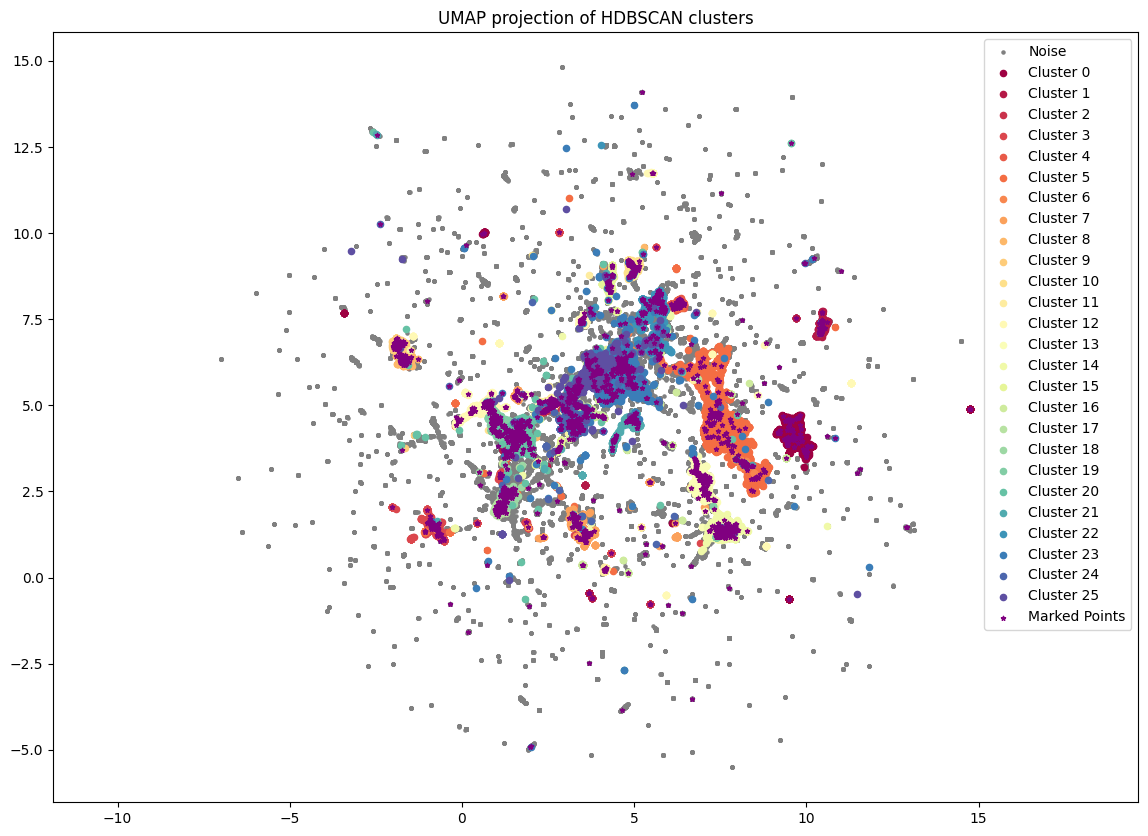

In [74]:
# Create a custom colormap where -1 (noise) is gray
unique_labels = np.unique(clusters)
cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)
cmap.set_over('gray')  # Set color for noise points (-1)

# Plot the clusters
plt.figure(figsize=(14, 10))

# Plot noise points in gray
noise_points = reduced_embeddings2[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='gray', s=5, label='Noise')

# Plot other clusters
for label in unique_labels[unique_labels != -1]:
    cluster_points = reduced_embeddings2[clusters == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(label)], s=20, label=f'Cluster {label}')

marked_points = reduced_embeddings2[sampled_idxs]
plt.scatter(marked_points[:, 0], marked_points[:, 1], c='purple', s=10, marker='*', label='Marked Points')


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of HDBSCAN clusters')
plt.legend()
plt.show()

### Удаление «почти дублей»  с помощью кластеризации на мини-кластеры


In [87]:
def remove_near_duplicates_hdbscan(selected_texts, embedding_dict, min_cluster_size=2):
    """
    Убирает «почти дубли» с помощью HDBSCAN.
    
    :param selected_texts: список текстов, в которых ищем дубликаты
    :param embedding_dict: словарь {текст: вектор np.ndarray}
    :param min_cluster_size: минимальный размер кластера. Если выставить 2,
                            то объединяются только тексты с близкими эмбеддингами.
    :return: список текстов без почти дублей
    """
    X = np.array([embedding_dict[text] for text in selected_texts])
    
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
    cluster_selection_method="leaf",
    metric="euclidean")
    labels = clusterer.fit_predict(X)

    unique_labels = np.unique(labels)
    deduped_texts = []
    idx = []
    
    for label in unique_labels:
        cluster_indices = np.where(labels == label)[0]
        representative_idx = cluster_indices[0]
        deduped_texts.append(selected_texts[representative_idx])
        idx.append(representative_idx)
        # cluster_indices = np.where(labels == label)[-1]
        # representative_idx = cluster_indices[-1]
        # deduped_texts.append(selected_texts[representative_idx])

    return deduped_texts, idx

In [ ]:
clean_texts, idx_dedup = remove_near_duplicates_hdbscan(
    selected_texts=final_texts_for_annotation,
    embedding_dict=embedding_dict,
    min_cluster_size=2
)

print("До удаления почти дублей:", len(final_texts_for_annotation))
print("После удаления почти дублей:", len(clean_texts))

/var/folders/1p/r5nrs13x0nb6qfb1xtb7ncl06v0pq3/T/ipykernel_31754/1769613524.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)


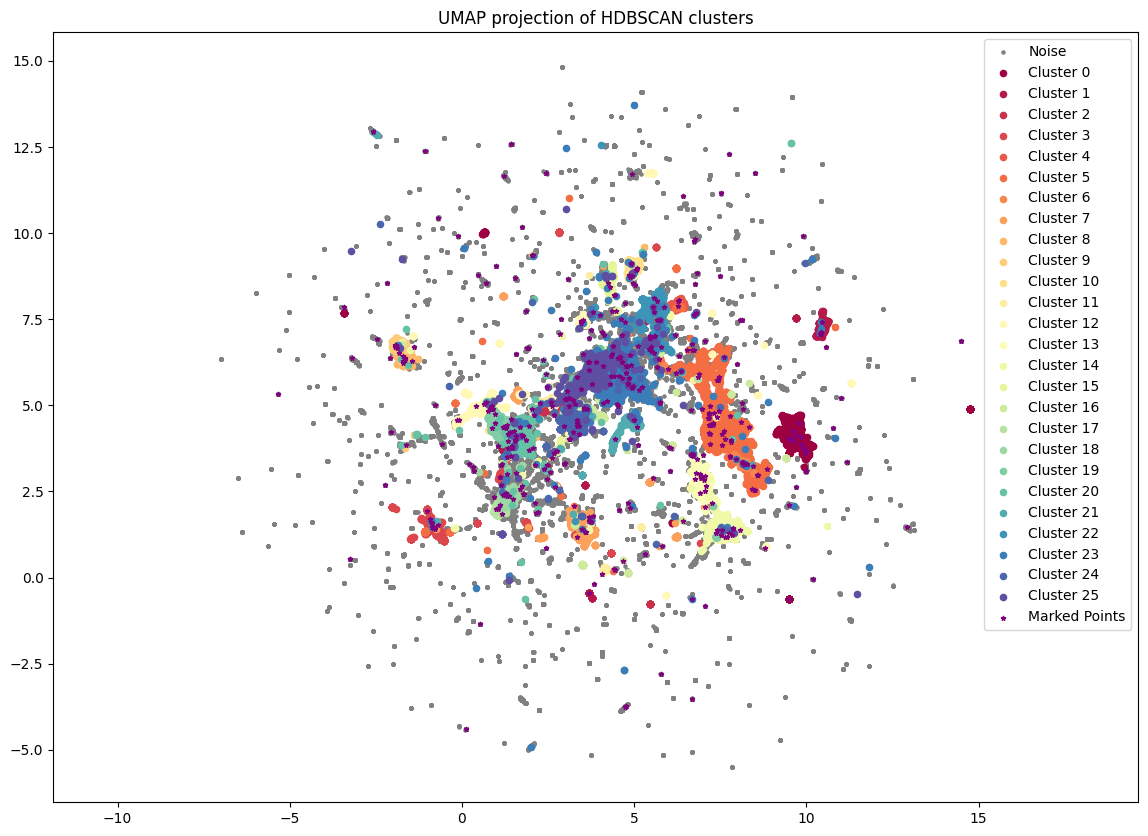

In [89]:
# Create a custom colormap where -1 (noise) is gray
unique_labels = np.unique(clusters)
cmap = plt.cm.get_cmap('Spectral', len(unique_labels) - 1)
cmap.set_over('gray')  # Set color for noise points (-1)

# Plot the clusters
plt.figure(figsize=(14, 10))

# Plot noise points in gray
noise_points = reduced_embeddings2[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], c='gray', s=5, label='Noise')

# Plot other clusters
for label in unique_labels[unique_labels != -1]:
    cluster_points = reduced_embeddings2[clusters == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(label)], s=20, label=f'Cluster {label}')

marked_points = reduced_embeddings2[idx_dedup]
plt.scatter(marked_points[:, 0], marked_points[:, 1], c='purple', s=10, marker='*', label='Marked Points')


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of HDBSCAN clusters')
plt.legend()
plt.show()